## QPE Implementation

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt

import numpy as np

In [2]:
## Inverse QFT 
def inverse_quantum_fourier_transform(n):
    quantum_register = QuantumRegister(size=n, name="x")
    inverse_QFT_circuit = QuantumCircuit(quantum_register, name=f"IQFT")

    for q, p in zip(quantum_register[:n >> 1], reversed(quantum_register[n >> 1:])):
        inverse_QFT_circuit.swap(q, p)
        
    for i, q in enumerate(reversed(quantum_register), start=1):
        for j, p in enumerate(reversed(quantum_register[n + 1 - i:]), start=1):
            inverse_QFT_circuit.cp(- np.pi / (1 << (i - j)), q, p)
        inverse_QFT_circuit.h(q)

    

    return inverse_QFT_circuit

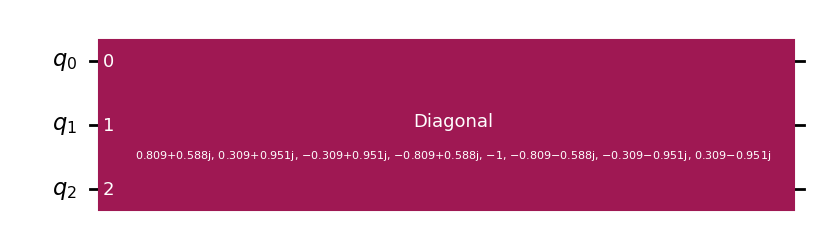

In [34]:
from qiskit.circuit.library import Diagonal
from qiskit.circuit.library import DiagonalGate


def theta_input(d,n):
    possible_thetas = np.arange(2**d)/2**d
    return np.random.choice(possible_thetas, size=2**n,replace=False)
    
    

def power_diag_U(power, n, thetas):
    diagonals = np.array([])
    if 2**n != len(thetas):
        raise Exception("2^n should be the same length as the array of phases.")
    
    for theta in thetas:
        diagonals = np.append(diagonals, np.exp(2*np.pi*1.j*theta))
    #diagonals = np.array([np.exp(2*np.pi*1.j*theta1),np.exp(2*np.pi*1.j*theta2),np.exp(2*np.pi*1.j*theta3),np.exp(2*np.pi*1.j*theta4),np.exp(2*np.pi*1.j*theta5),np.exp(2*np.pi*1.j*theta6),np.exp(2*np.pi*1.j*theta7),np.exp(2*np.pi*1.j*theta8)])**power
 
    return diagonals.tolist()

def power_U(power, n, thetas):
    diagonals = power_diag_U(power, n, thetas)
    qc = QuantumCircuit(n, name=f"U")

    qc.append(DiagonalGate(diagonals), range(n))

    return qc

power_U(2,3,[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]).draw(output="mpl")
    
    

In [33]:
np.random.choice(np.arange(2**3)/2**3,size=4,replace=False)

array([0.25 , 0.5  , 0.375, 0.875])

In [68]:
def QPE(d,n,thetas):
    qr_0 = QuantumRegister(size=d, name="0")
    qr_psi = QuantumRegister(size=n, name="psi")

    qc = QuantumCircuit(qr_0, qr_psi,name=f'QPE')

    
    #Hadamard gates on each |0>_d
    
    for i in range(d):
        qc.h(qr_0[i])

        U_i = power_U(2**i,n,thetas).to_gate(label="U"+str(i))
        U_i_controlled = U_i.control(1)


        qc.append(U_i_controlled, [qr_0[i]] + qr_psi[:])

    

    #Swap

    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)
    
    
    #Inverse QFT
    qc.append(inverse_quantum_fourier_transform(d),qr_0[:])

    #Swap
    for q, p in zip(qr_0[:d >> 1], reversed(qr_0[d >> 1:])):
        qc.swap(q, p)

    return qc

    

    
    

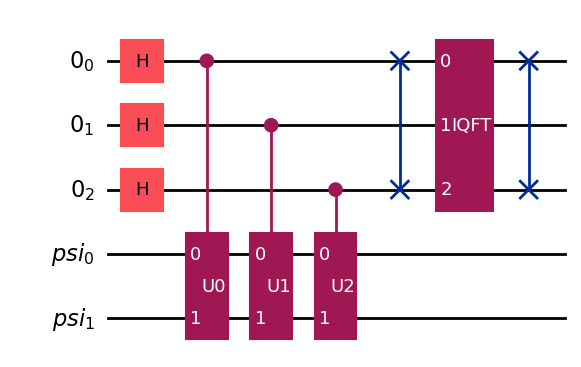

In [74]:
d = 3
n = 2
thetas = theta_input(d,n)
QPE(d,n,thetas).draw(output="mpl")

In [58]:
# n = 3 , d = 3

thetas = theta_input(3,3)

U = power_U(2**0,3,thetas).to_gate(label="U")
U_controlled = U.control(1)

U2 = power_U(2**1,3,thetas).to_gate(label="U2")
U2_controlled = U2.control(1)

U3 = power_U(2**2,3,thetas).to_gate(label="U3")
U3_controlled = U3.control(1)

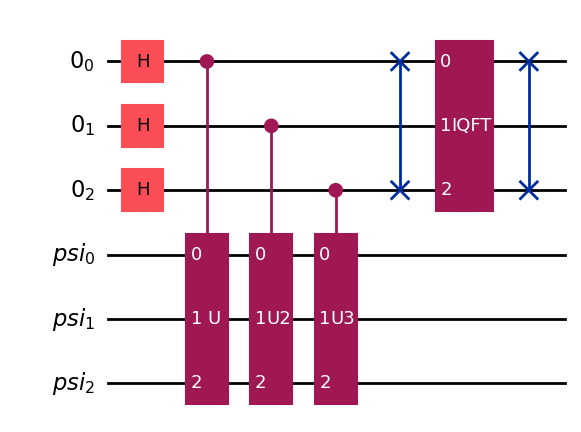

In [60]:

qr_0 = QuantumRegister(size=3, name="0")
qr_psi = QuantumRegister(size=3, name="psi")


qc = QuantumCircuit(qr_0, qr_psi,name=f'QPE')



qc.h(0)
qc.h(1)
qc.h(2)



qc.append(U_controlled, [qr_0[0]] + qr_psi[:])  # Controls: 0, 3; Targets: 1
qc.append(U2_controlled, [qr_0[1]]+qr_psi[:])  # Controls: 1, 3; Targets: 1
qc.append(U3_controlled, [qr_0[2]]+qr_psi[:])  # Controls: 2, 3; Targets: 1


qc.swap(0,2)
qc.append(inverse_quantum_fourier_transform(3),[0,1,2])
qc.swap(0,2)

qc.draw(output="mpl")

In [52]:
qr_psi[:]

[<Qubit register=(3, "psi"), index=0>,
 <Qubit register=(3, "psi"), index=1>,
 <Qubit register=(3, "psi"), index=2>]

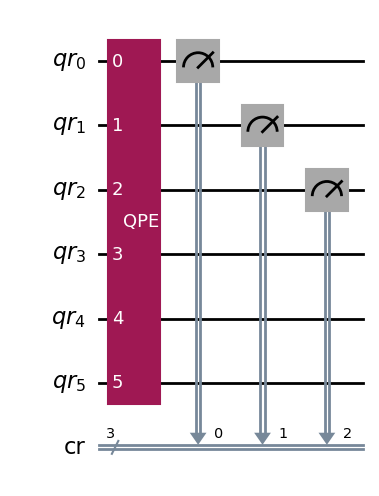

In [323]:
cr = ClassicalRegister(size=3, name="cr")
qr = QuantumRegister(size=6, name="qr")
qc_m = QuantumCircuit(qr,cr,name=f'meas')
qc_m.append(qc,[0,1,2,3,4,5])
qc_m.measure([0,1,2],[0,1,2])
qc_m.draw(output="mpl")

In [324]:
def bit_string(num,n): # converts a number to binary bit_string
    """Converts a number to its binary string with MSB to LSB from left to right.
    Input: number (num), n (number of bits that should be in result)
    """
    maxi = 2**n
    rem = num%(2**n)

    bit_string = ''# 2^(n-1) ... 2^0 

    for i in range(n-1,-1,-1):
        append = str(rem//(2**i))
        bit_string = bit_string + append
        rem = rem%(2**i)
    return bit_string

def binary_to_num(bit_str):
    """Convert a bit-string to a number.
    Input : bit-string in binary
    Output: number 
    """
    num=0
    n=len(bit_str)
    
    for i in range(n):
        bit = int(bit_str[i])
        if bit < 0 or bit > 1:
            print("Fatal error. You did not input a bit string.Exiting.")
            return 0
        num = num + bit*2**(n-1-i)
    return num


def bit_string_input(num,d,n): # converts psi number to bit string input
    bit_str = bit_string(num,n)[::-1]
    for i in range(d):
        bit_str = "0"+bit_str #first d quibits are zero.
    return bit_str

def num_output(bit_string,d,n): # converts psi number to bit string input
    if len(bit_string)!= d+n:
        raise Exception("Error. Exit.")
    summ = 0

    for i in range(n):
        summ = summ + 2**i*int(bit_string[i+d])

    print("The output value of psi is", summ)
    
    summ=0 
    for i in range(d):
        summ = summ + 2**i*int(bit_string[i]) # read what number is in the |0> qubits after QPE.
        
    return summ

def bit_to_state(bit_str): #convert bit_string to state_vector
    """ Converts a bit-string to an input state vector for the circuit.
    """
    bit_str = bit_str[::-1]
    #
    return Statevector.from_label(bit_str)
def state_to_bit(statevector,n): # converts state_vector to bit_string
    """ Converts an input statevector to a bit-string of length n
    """
    num = np.nonzero(np.round(np.real(statevector)))[0][0]
   
    return bit_string(num,n)



In [325]:
np.nonzero(bit_to_state(bit_string_input(num+1,d,n)))

(array([32]),)

In [326]:
bit_string(num,6)

'000011'

In [331]:
d=3
n = 3
total_bits = d+n

num = 2

bit_str = bit_string_input(num,d,n)
print("bit_str",bit_str)
sv_ini = bit_to_state(bit_str)
print("Initial state vector is",sv_ini)
sv_fin = sv_ini.evolve(qc)
print("Final state vector is", sv_fin)
#state_to_bit(sv_fin,total_bits)

bit_str 000010
Initial state vector is Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2))
Final state vector is Statevector([ 0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+0.00000000e+00j,
              0.00000000e+00+

In [332]:
sv_fin.probabilities()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.35926418e-32, 2.10417156e-32, 1.00000000e+00, 2.10417156e-32,
       2.51333858e-32, 3.61018765e-33, 1.44973419e-33, 3.61018765e-33,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [336]:
 # Your evolved statevector
probs = sv_fin.probabilities()
n_qubits = sv_fin.num_qubits
num_output(bit_string(np.random.choice(2**n_qubits,p=probs),n_qubits)[::-1],d,n)

The output value of psi is 2


2

In [ ]:
sv.measure(qargs=[0,1,2])[1].data